# Measurement

In [13]:
import time
from datetime import datetime
import numpy as np
from sciopy import (
    SystemMessageCallback_usb_hs,
    available_serial_ports,
    connect_COM_port,
    connect_COM_port_usb_hs,
    reshape_full_message_in_bursts,
    set_measurement_config_usb_hs,
    split_bursts_in_frames,
)
from sciopy.sciopy_dataclasses import ScioSpecMeasurementSetup

from src.classes import (
    BallAnomaly,
    Ender5Stat,
    HitBox,
    MeasurementInformation,
    TankProperties32x2,
)
from src.ender5 import (
    init_ender5,
    move_ender_to_coordinate,
    move_to_absolute_x_y_z,
    x_y_z_home,
    read_temperature,
)
from src.functions import (
    compute_hitbox,
    create_meas_coordinates,
    create_measurement_directory,
    create_mesh,
    print_coordinates_props,
    rename_savedir,
    save_parameters_to_json_file,
    set_perm,
)
from src.sciospec import sciospec_measurement
from src.visualization import plot_meas_coords, plot_meas_coords_wball, plot_mesh

## Define the parameters

In [2]:
# init tank
tank = TankProperties32x2()
# init ball
ball = BallAnomaly(x=0, y=0, z=0, d=30, perm=10, material="acryl")
# init hitbox
hitbox = compute_hitbox(tank, ball, safety_tolerance=5.0)
# set sciospec measurement properties
ssms = ScioSpecMeasurementSetup(
    burst_count=5,  # The number of measurements to be performed.
    total_meas_num=10,  # Repetitions of burst count
    n_el=64,  # Set 16, 32, 48 or 64 and do not forget to change the channel_group.
    channel_group=[
        1,
        2,
        3,
        4,
    ],  # Use [1] for n_el=16, [1,2] for n_el=32, [1,2,3] for n_el=48, and [1,2,3,4] for n_el=64
    exc_freq=20_000,  # 10,000Hz = 10kHz
    framerate=5,  # Measurements per second
    amplitude=0.01,  # 0.01A = 10mA (maximum)
    inj_skip=8,  # injection electrode skip
    gain=1,
    adc_range=1,  # +/- 1V
    notes="test measurement",  # add measurement information
    configured=True,
)

# measurement information for documentation
today = datetime.now()
documentation = MeasurementInformation(
    saline=(0.0, "[mS]"),
    saline_height=(0.0, "[mm]"),
    temperature=(0.0, "[°C]"),
    timestamp=today.strftime("%d_%m_%Y_%Hh_%Mm"),
)

print(tank)
print(ball)
print(hitbox)
print(ssms)
print(documentation)

TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64)
BallAnomaly(x=0, y=0, z=0, d=30, perm=10, material='acryl')
HitBox(r_min=0, r_max=77.0, x_min=-77.0, x_max=77.0, y_min=-77.0, y_max=77.0, z_min=20.0, z_max=128.0)
ScioSpecMeasurementSetup(burst_count=5, total_meas_num=10, n_el=64, channel_group=[1, 2, 3, 4], exc_freq=20000, framerate=5, amplitude=0.01, inj_skip=8, gain=1, adc_range=1, notes='test measurement', configured=True)
MeasurementInformation(saline=(0.0, '[mS]'), saline_height=(0.0, '[mm]'), temperature=(0.0, '[°C]'), timestamp='13_11_2023_15h_09m')


In [3]:
coordinates = create_meas_coordinates(hitbox, x_pts=3, y_pts=3, z_pts=3)
print_coordinates_props(coordinates)

HitBox(x_pts,y_pts,z_pts) leads to 15 available points.
So 15 points will be measured.
Properties of the computed coordinates
--------------------------------------
min:-77.00	max: 77.00
min:-77.00	max: 77.00
min:20.00	max: 128.00

shape (15, 3)


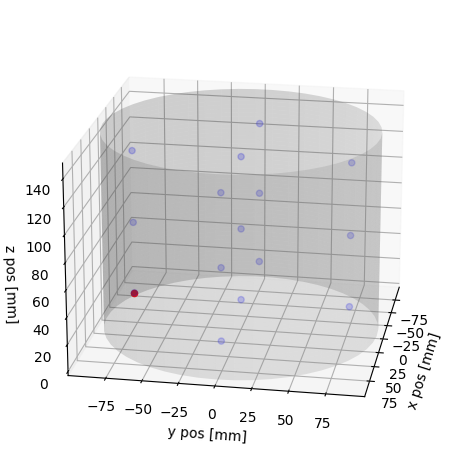

In [4]:
plot_meas_coords(tank=tank, meas_coords=coordinates, p_select=0)

In [5]:
s_path, f_name = create_measurement_directory()
save_parameters_to_json_file(s_path, f_name, ssms, tank, ball, hitbox)

Created new measurement directory at: measurements/13_11_2023_15h_09m
Saved properties to: measurements/13_11_2023_15h_09m/data/


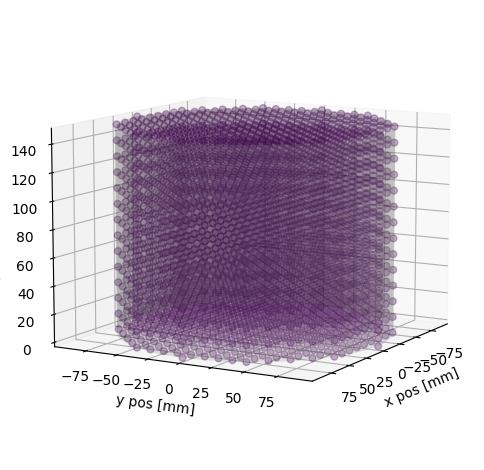

In [6]:
# create an empty mesh
mesh_obj = create_mesh(tank)
plot_mesh(mesh_obj, tank, show_tank_brdr=True)

## Connect Devices

- Create 3D objects
- Init Ender 5
- Centering object depending on size
- Init Sciospec
- Send config to sciospec
- Start Measurement

In [7]:
COM_Ender = connect_COM_port(port="COM4", baudrate=115200)
COM_Sciospec = connect_COM_port_usb_hs()

Connection to COM4 is established.


In [8]:
enderstat = Ender5Stat(
    abs_x_pos=None,
    abs_y_pos=None,
    abs_z_pos=None,
    tank_architecture=TankProperties32x2(),
    motion_speed=180,
)

In [9]:
# init axis -> RUN ONLY IF NO OBJECT IS IN THE MOUNTING CONSTRUCTION
init_ender5(COM_Ender, enderstat)

In [10]:
# move to home position
x_y_z_home(COM_Ender, enderstat, print_msg=True)

b'ok\n'
Ender5Stat(abs_x_pos=180, abs_y_pos=180, abs_z_pos=0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=180)


## Set Sciospec Config

In [11]:
set_measurement_config_usb_hs(COM_Sciospec, ssms)

In [13]:
# Read out system callback
SystemMessageCallback_usb_hs(COM_Sciospec, prnt_msg=True)

No message inside the message buffer


## Measurement

In [10]:
enderstat.abs_x_pos = 180
enderstat.abs_x_pos = 180
enderstat.abs_z_pos = 50
move_to_absolute_x_y_z(COM_Ender, enderstat)

b'ok\n'


In [17]:
# move to start position
move_ender_to_coordinate(COM_Ender, coordinates[0], enderstat, print_msg=True)

b'ok\n'
Ender5Stat(abs_x_pos=103.0, abs_y_pos=180.0, abs_z_pos=20.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=180)
Ender5Stat(abs_x_pos=103.0, abs_y_pos=180.0, abs_z_pos=20.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=180)


In [16]:
samples_counter = 0

for XYZ in coordinates:
    # update ball position
    ball.x, ball.y, ball.z = XYZ
    mesh_obj = set_perm(mesh_obj, ball)
    plot_mesh(mesh_obj, tank, show_tank_brdr=True)
    # move to position
    move_ender_to_coordinate(COM_Ender, XYZ, enderstat, print_msg=True)
    time.sleep(3)
    # update documentation
    documentation.temperature = read_temperature(COM_Ender)
    current_time = datetime.now()
    documentation.timestamp = current_time.strftime("%d_%m_%Y_%Hh_%Mm")
    # measurement
    sciospec_data = sciospec_measurement(COM_Sciospec, ssms)

    save = True
    if save:
        for data in sciospec_data:
            # update documentation timestamp
            current_time = datetime.now()
            documentation.timestamp = current_time.strftime("%d_%m_%Y_%Hh_%Mm")

            np.savez(
                s_path + "sample_{0:06d}.npz".format(samples_counter),
                data=data,
                anomaly=ball,
                mesh_obj=mesh_obj,
                config=ssms,
                tank=tank,
                documentation=documentation,
            )
            samples_counter += 1
        SystemMessageCallback_usb_hs(COM_Sciospec, prnt_msg=False)

# rename the timestamp dir
rename_savedir(s_path, ball=ball, ssms=ssms)
x_y_z_home(COM_Ender, enderstat)

b'ok\n'
Ender5Stat(abs_x_pos=103.0, abs_y_pos=180.0, abs_z_pos=20.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=180)
Ender5Stat(abs_x_pos=103.0, abs_y_pos=180.0, abs_z_pos=20.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=180)
Starting measurement.
Stopping measurement.
b'ok\n'
Ender5Stat(abs_x_pos=103.0, abs_y_pos=180.0, abs_z_pos=74.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=180)
Ender5Stat(abs_x_pos=103.0, abs_y_pos=180.0, abs_z_pos=74.0, tank_architecture=TankProperties32x2(T_d=194, T_r=97, T_bx=(-97.0, 97.0), T_by=(-97.0, 97.0), T_bz=(0, 148), E_zr1=50, E_zr2=100, n_el=64), motion_speed=180)
Starting measurement.
Stopping measurement.
b'ok\n'
Ender5Stat(a